In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
import tables as tb
sys.path.insert(0, '../src/')
import deployer
import time
import warnings
warnings.filterwarnings("ignore")

Instanciate the forecaster, paths and additional parameters:

In [3]:
forecaster = deployer.Deployer()

data_path = '../data/input/example.h5'
predict_path = '../data/predictions/predictions.h5'
server = 'FogServer01'
year = '2010'
month = '03'
day = '20'
horizons = {0:1,1:11,2:31,3:61}
horizons_r = {v:k for k,v in horizons.items()}

Check for available dates:

In [17]:
with tb.open_file(data_path, 'r') as h5:
    available_days = h5.root.DataCenter.FogServer01._v_children.keys()
available_days

dict_keys(['2010-03-20', '2010-03-21', '2010-03-22', '2010-03-23', '2010-03-24', '2010-03-25'])

Generate predictions:

In [8]:
tic = time.time() 
warnings.filterwarnings("ignore")
for i in pd.date_range(f'{year}/{month}/{day} 07:40:00',f'{year}/{month}/{day} 16:30:00',freq='min'):
    forecaster.forecast(now=i)
print('it took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

Unable to forecast at times before 07:40 and after 16:29
it took 00:02:56 in total


Extract data and predictions:

In [15]:
n_sensors = 17
n_horizons = 4
n = f'{year}-{month}-{day}'
with tb.open_file(predict_path, 'r') as h5_preds,\
    tb.open_file(data_path, 'r') as h5_data:
    timestamps = h5_preds.root.DataCenter[server][n]._v_children.keys()
    timestamps = list(timestamps)
    preds = np.empty((len(timestamps), n_sensors, n_horizons))
    data = np.empty((len(timestamps), n_sensors))
    for idx, t in enumerate(timestamps):
        preds[idx] = h5_preds.root.DataCenter[server][n][t][:]
        data[idx] = h5_data.root.DataCenter[server][n][idx,1:]
    sensors = h5_data.root.DataCenter[server]._v_attrs['columns'][1:]
times = [pd.to_datetime(d) for d in timestamps]



Plot predictions and real data:

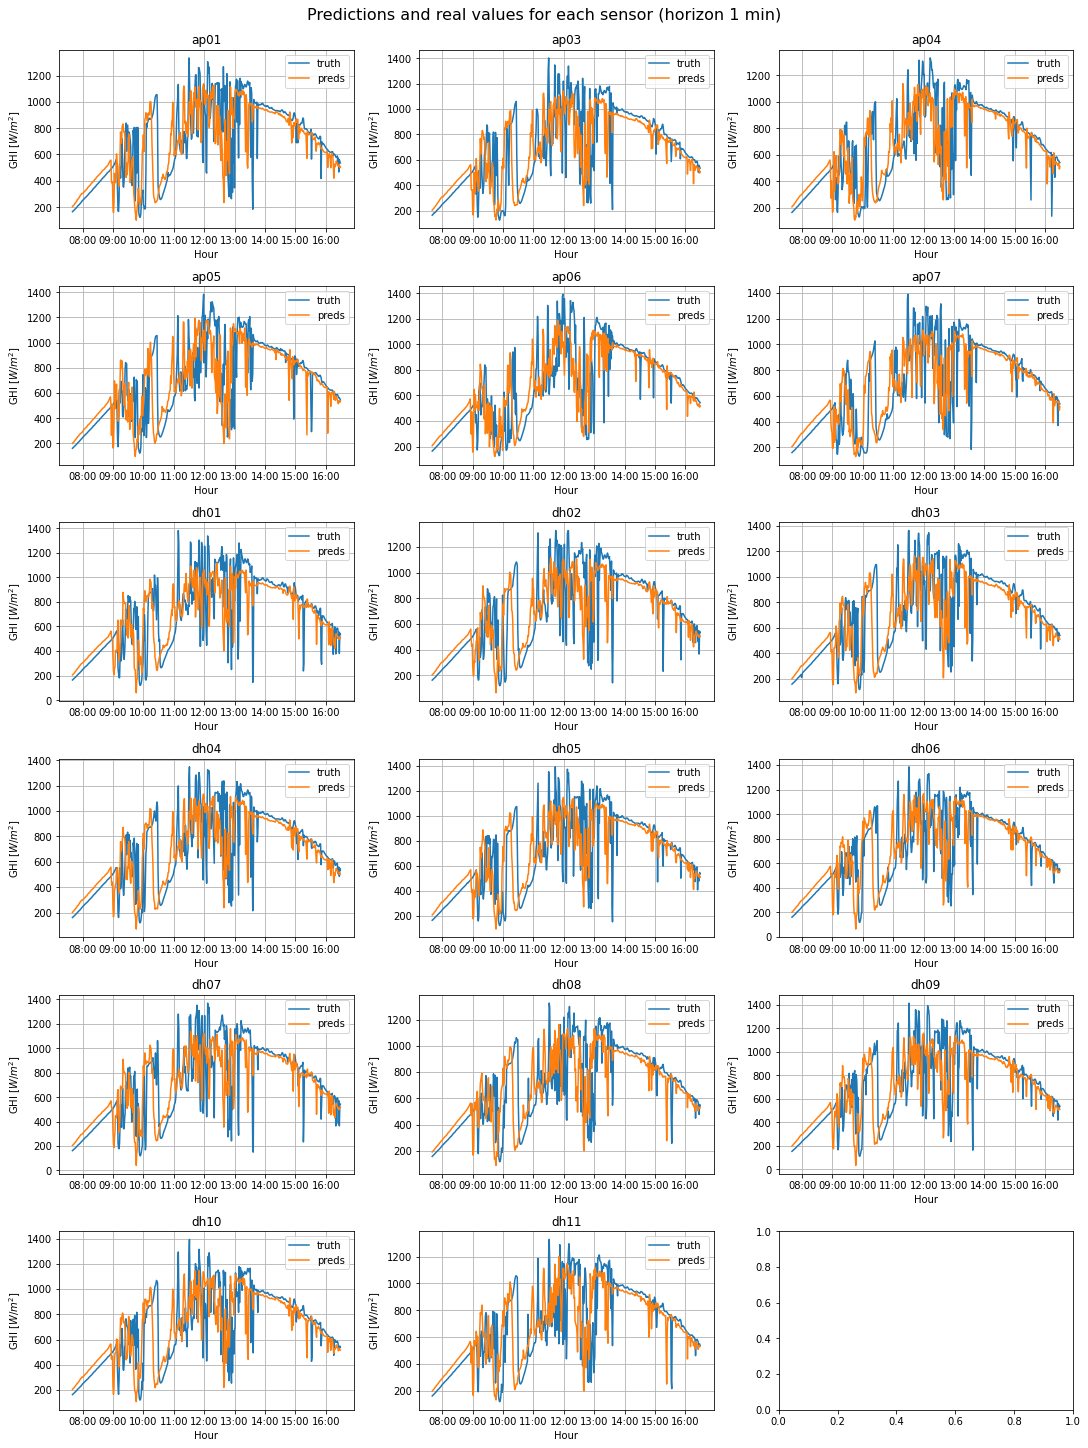

In [13]:
h = 0

fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
fig.suptitle('Predictions and real values for each sensor (horizon {} min)'.format(horizons[h]), fontsize=16)
for i in range(17):
    ax[i//3,i%3].set_title(label=sensors[i])
    ax[i//3,i%3].plot(times, data[:,i], label='truth')
    ax[i//3,i%3].plot(times, preds[:,i,h], label='preds')
    ax[i//3,i%3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i//3,i%3].grid()
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_ylabel('GHI $[W/m^2]$')
    # ax[i//3,i%3].set_xlabel('minutes since first prediction')

    # ax.plot(x, true)
    ax[i//3,i%3].set_xlabel('Hour') #, fontsize=12)

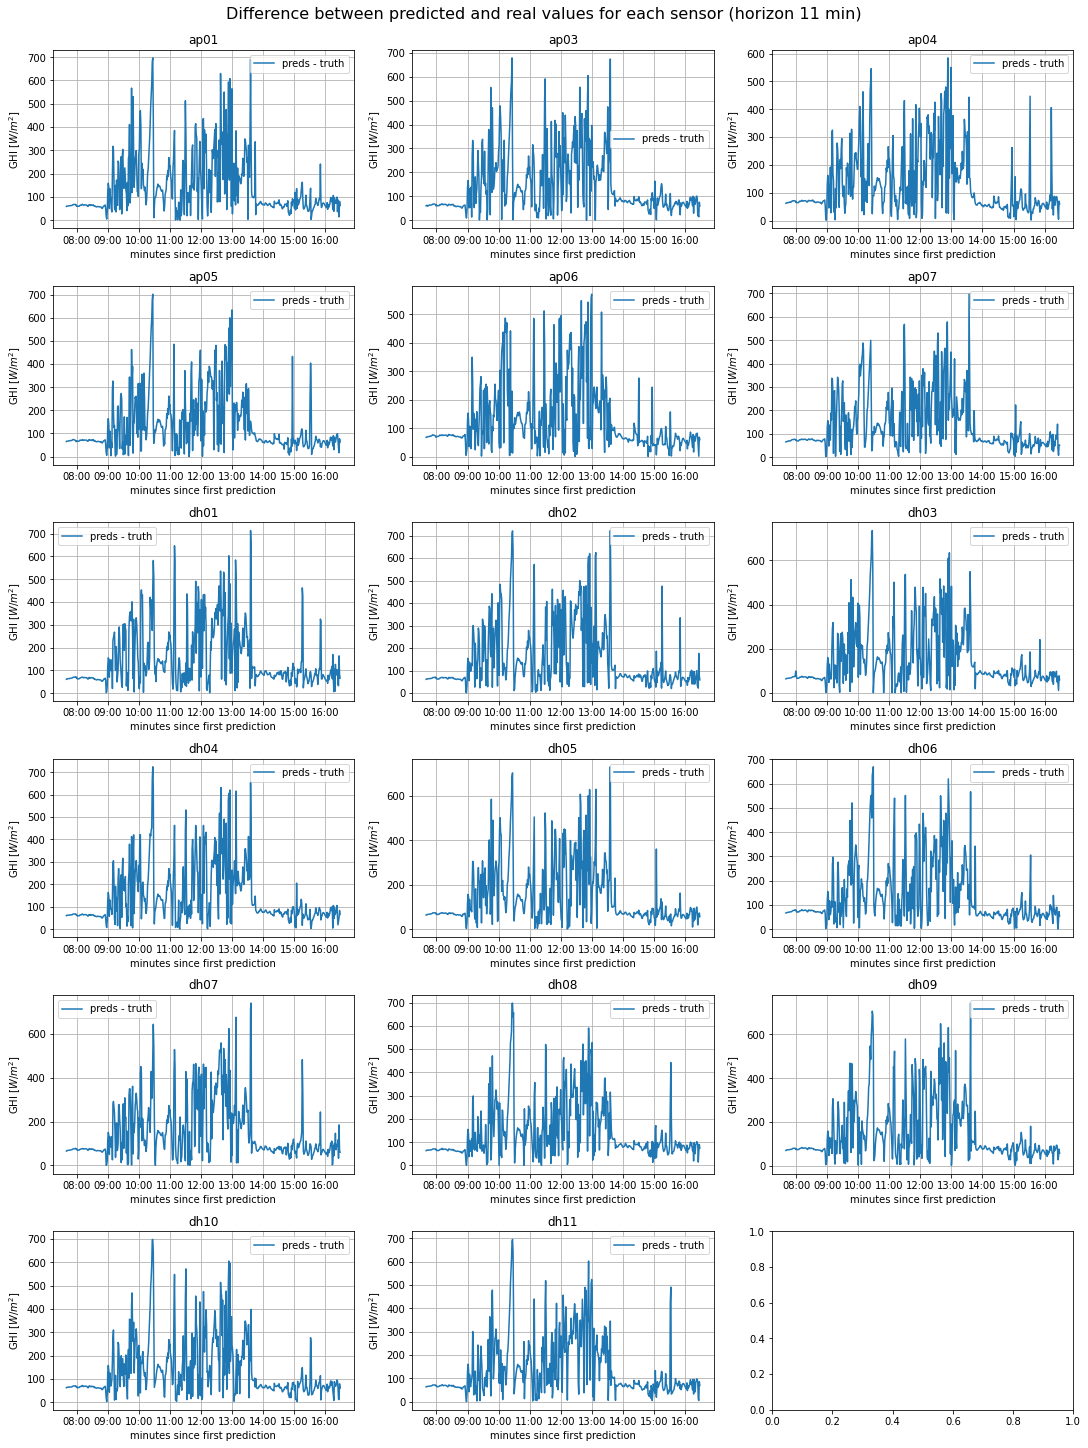

In [14]:
h =1

fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
fig.suptitle('Difference between predicted and real values for each sensor (horizon {} min)'.format(horizons[h]), fontsize=16)
for i in range(17):
    ax[i//3,i%3].set_title(label=sensors[i])
    ax[i//3,i%3].plot(times, np.abs(preds[:,i,h] - data[:,i]), label='preds - truth')
    ax[i//3,i%3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax[i//3,i%3].grid()
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_ylabel('GHI $[W/m^2]$')
    ax[i//3,i%3].set_xlabel('minutes since first prediction')

Dataframes for MAE and RMSE for each horizon and each sensor:

In [10]:
df = pd.DataFrame(columns=[*sensors, 'mean'], index=['1 min','11 min','31 min','61 min', 'mean'])
for idx,i in enumerate(['1 min','11 min','31 min','61 min']):
    df.loc[i] = [*np.nanmean(np.abs(preds[...,idx] - data), axis=0).round(2), np.nanmean(np.abs(preds[...,idx] - data), axis=(0,1)).round(2)]  
df.loc['mean'] = [
    *np.mean([np.abs(preds[...,j] - data) for j in range(4)], axis=(0,1)).round(2),
    np.mean([np.abs(preds[...,j] - data) for j in range(4)]).round(2)]
df.index.name = 'MAE'
df.T

MAE,1 min,11 min,31 min,61 min,mean
ap01,147.78,141.53,166.02,203.79,164.78
ap03,152.07,144.74,168.19,204.14,167.29
ap04,138.21,128.92,152.44,185.80,151.34
ap05,150.91,135.32,158.28,192.66,159.29
ap06,133.22,126.33,146.48,178.82,146.21
ap07,141.69,136.43,160.68,194.59,158.35
dh01,148.21,148.42,172.99,211.24,170.21
dh02,153.80,150.49,176.85,212.51,173.41
dh03,154.50,149.45,173.52,210.72,172.05
dh04,148.96,144.50,169.49,206.63,167.39


In [11]:
df = pd.DataFrame(columns=[*sensors, 'mean'], index=['1 min','11 min','31 min','61 min', 'mean'])
for idx,i in enumerate(['1 min','11 min','31 min','61 min']):
    df.loc[i] = [*np.sqrt(np.nanmean((preds[...,idx] - data)**2, axis=0)).round(2), np.sqrt(np.nanmean((preds[...,idx] - data)**2, axis=(0,1))).round(2)]  
df.loc['mean'] = [
    *np.sqrt(np.mean([(preds[...,j] - data)**2 for j in range(4)], axis=(0,1))).round(2),
    np.sqrt(np.mean([(preds[...,j] - data)**2 for j in range(4)])).round(2)]
df.index.name = 'RMSE'
df.T

RMSE,1 min,11 min,31 min,61 min,mean
ap01,228.13,189.41,203.45,234.31,214.60
ap03,228.84,189.48,204.01,233.73,214.78
ap04,208.90,170.03,181.83,210.12,193.50
ap05,231.68,181.84,194.48,221.87,208.44
ap06,204.83,170.58,181.45,209.77,192.34
ap07,216.04,179.35,193.17,221.30,203.18
dh01,220.37,196.52,211.14,242.67,218.32
dh02,236.16,204.77,218.49,246.71,227.11
dh03,232.38,197.27,212.42,243.14,222.01
dh04,226.74,194.01,208.18,238.41,217.50
